# Image recognition of vehicle's make and model using TensorFlow

In [1]:
import sys
print (sys.version)

3.5.5 |Anaconda, Inc.| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]


In [2]:
# function to open tensorboard in jupyter
def TB(cleanup=False):
    import webbrowser
    webbrowser.open('http://127.0.1.1:6006')

    !tensorboard --logdir="logs"

    if cleanup:
        !rm -R logs/

### Import necessary libraries

In [3]:
import os
import pandas as pd
from os.path import splitext
import numpy as np

import tensorflow as tf

# Import tflearn and some helpers
import tflearn
from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [4]:
os.chdir("C:/Users/mednche/Desktop/ImageRec/Test")

### Get name of all images in folder

In [5]:
# Get all files in merged folder
folder = "C:/Users/mednche/Desktop/ImageRec/Test"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlyfiles)))

# due to low memory available, I restricted the dataset size
onlyfiles = onlyfiles[:5000]
print("Reduced to {0} images".format(len(onlyfiles)))


Working with 105152 images
Reduced to 5000 images


### Fetch the labels associated with each images

In [6]:
train_files = []
y_train =  pd.DataFrame()

# import the metadata for the cars
data =  pd.read_csv("../metadata.csv")

for _file in onlyfiles:
    # add file name to list of train_file
    train_files.append(_file)
    
    # remove name extension 
    file = splitext(_file)[0]
    
    # get id of vehicle
    car_id = file.split("_")[0]
    
    # get corresponding make
    make = data[data.id == car_id].make.tolist()[0]
    model = data[data.id == car_id].model.tolist()[0]
    name = car_id
    
    y_train = y_train.append({'name': name, 'make':make, 'model':model}, ignore_index=True)
    
print("Files in train_files: {}".format(len(train_files)))

Files in train_files: 5000


### Check the data

#### Check all vehicles have 16 images each (from different angles)

In [7]:
# number of images per vehicle
df = y_train.groupby(y_train.name).count()
df[df.make != 16]
# Good, all cars have a label attached in "metadata.csv"

,make,model
name,,
0d4b67f458bb,8,8


All but one vehicle does not have 16 images (only has 8 images). This is due to the subsampling of 5000 images. We'll still include that car in the training set nontheless for now.

#### Check that all images have a label in 'metadata.csv'

In [8]:
# number of images and vehicles
print("The dataset has got {} images of {} unique vehicles".format(len(onlyfiles), len(y_train.name.unique())))


The dataset has got 5000 images of 313 unique vehicles


#### Example of an image and its labels

In [9]:
# Example of the first image...
import matplotlib.pyplot as plt
from scipy import misc

image = misc.imread(onlyfiles[0])
print(plt.imshow(image, cmap=plt.cm.gray))

# ...And corresponding labels (make and model)
y_train.iloc[0]

AxesImage(80,52.8;496x369.6)


C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


make            Acura
model              TL
name     0004d4463b50
Name: 0, dtype: object

### Initialise empty array where to add images 

In [10]:
# Open the first image (all images have the same size)
from PIL import Image
im = Image.open(folder + "/" + train_files[0])

# set size here
size = 450, 450 

# resize
im.thumbnail(size,Image.ANTIALIAS)

# crop
img = im.crop((0, 50, im.size[0], im.size[1]))

# get final dimentions of all images
image_width, image_height = img.size

# set number of colour channels 
channels = 3

# for training on coloured images
dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype='uint8')

dataset

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ..., 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
     

### Add all images to an array

In [11]:
i = 0
for _file in train_files:
    #img = load_img(folder + "/" + _file)  # this is a PIL image
    
    
    img = Image.open(folder + "/" + _file)
    # resize
    img.thumbnail(size,Image.ANTIALIAS)
    # crop top of image to reduce size             
    img = img.crop((0, 50, im.size[0], im.size[1]))
    #plt.imshow(img, cmap=plt.cm.gray) 
    
    # Convert to Numpy Array
    x = np.array(img)  
   
    # Normalize
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print("{} images to array".format(i))
print("All images to array!")

dataset

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
All images to array!


array([[[[238, 234, 235],
         [238, 234, 235],
         [238, 234, 235],
         ..., 
         [230, 226, 223],
         [230, 226, 223],
         [230, 226, 223]],

        [[238, 234, 235],
         [238, 234, 235],
         [238, 234, 235],
         ..., 
         [229, 225, 222],
         [229, 225, 222],
         [229, 225, 222]],

        [[238, 234, 235],
         [238, 234, 235],
         [238, 234, 235],
         ..., 
         [229, 225, 222],
         [229, 225, 222],
         [229, 225, 222]],

        ..., 
        [[209, 207, 215],
         [212, 211, 218],
         [212, 211, 218],
         ..., 
         [225, 221, 222],
         [224, 220, 221],
         [224, 220, 221]],

        [[212, 212, 214],
         [212, 212, 214],
         [212, 212, 214],
         ..., 
         [225, 221, 222],
         [225, 221, 222],
         [225, 221, 222]],

        [[212, 212, 210],
         [212, 212, 210],
         [212, 212, 210],
         ..., 
         [235, 231, 232],
  

### Recode car labels (make, model, id) into numbers instead of strings

In [12]:
# Associate each unique make with a number
maketonumberdict = {}
unique_make = y_train.make.unique() 
for i in range(len(unique_make)):
    maketonumberdict[unique_make[i]] = i 

# Associate each unique model with a number                  
modeltonumberdict = {}
unique_model = y_train.model.unique() 
for i in range(len(unique_model)):
    modeltonumberdict[unique_model[i]] = i

# Associate each unique id string with a number                  
idtonumberdict = {}
unique_id = y_train.name.unique() 
for i in range(len(unique_id)):
    idtonumberdict[unique_id[i]] = i

    
def makeAndModelToNumber(mydata, makedict, modeldict, iddict):
    mydata_copy = mydata.copy() # make a copy otherwise the changes are made in both df
    for i in range(len(mydata_copy['make'])):
        mydata_copy.loc[i,'make'] = makedict[mydata_copy.loc[i,'make']]
        mydata_copy.loc[i,'model'] = modeldict[mydata_copy.loc[i,'model']]
        mydata_copy.loc[i,'name'] = iddict[mydata_copy.loc[i,'name']]
    return mydata_copy

clean_y_train = makeAndModelToNumber(y_train, maketonumberdict, modeltonumberdict, idtonumberdict)
clean_y_train

,make,model,name
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


# Training the model

## 1. With make, model and id

### Reset tensorflow graph data

In [20]:
# reset underlying graph data
tf.reset_default_graph()
tf.get_default_graph().get_operations()

os.chdir("C:/Users/mednche/Desktop/ImageRec/") # change directory to save checkpoint of model

### Define network architecture and train model

##### This takes around 25 mins with 5000 images on a batch size of 10 and 10 epoch

In [ ]:
from sklearn.model_selection import train_test_split

with tf.Graph().as_default():
    
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, clean_y_train, test_size=0.2, random_state=33)
    
    # trainx and trainy should be numpy arrays
    y_train = np.array(y_train, dtype = 'uint8')
    y_test = np.array(y_test, dtype = 'uint8')
    
    # Make sure the data is normalized
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()


    ### Define our network architecture:
    
    # Input is a tensor: height*width images with 3 color channels (red, green and blue) 
    
    network = input_data(shape=[None, image_height, image_width, channels],
                         data_preprocessing=img_prep)
    
    # Step 1: Convolution
    # NB: low level recognises edges and cruves, high level recognises wheels, signs
    network = conv_2d(network, 5, 7, activation='relu') # number of filters: 3, filter size 3 
    # need downsampling to reduce the size of the image
    
    # Step 2: Max pooling
    network = max_pool_2d(network, 2) # kernel size
    
    # Step 3
    network = conv_2d(network, 5, 3, activation='relu') # number of filters: 3, filter size 3 
    
    # Step 4: Max pooling
    network = max_pool_2d(network, 2) # kernel size
                        
    # Step 5: Fully-connected 3 node neural network
    # Looks at all images for each class and identify the high level features in common
    network = fully_connected(network, 3, activation='relu') # number of outputs = number of classes the model has to choose from
    
    # Step 6: Regression
    network = tflearn.regression(network)
                             
    
    # Wrap the network in a model object
    model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='/tmp/tflearn_logs/')
    
    %time model.fit(X_train, y_train, validation_set=(X_test, y_test), show_metric=True, batch_size=10) # batch size of 56 or even 10 is too much
    
    # Save model when training is complete to a file
    model.save("carclassifier.tfl")
    
    print("Network trained and saved as car-classifier.tfl!")
    
    score = model.evaluate(X_test, y_test, batch_size=10)
    # accuracy: 0.94599999427795411
    # loss: 363.87445
    
    print("Accuracy of the model: {}".format(score))

---------------------------------
Run id: JQCZOF
Log directory: /tmp/tflearn_logs/
---------------------------------
Preprocessing... Calculating mean over all dataset (this may take long)...
Mean: 171.435942419 (To avoid repetitive computation, add it to argument 'mean' of `add_featurewise_zero_center`)
---------------------------------
Preprocessing... Calculating std over all dataset (this may take long)...
STD: 62.2912249241 (To avoid repetitive computation, add it to argument 'std' of `add_featurewise_stdnorm`)
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 4000
Validation samples: 1000
--


Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tflearn\data_flow.py", line 195, in fill_feed_dict_queue
    data[k] = self.dprep_dict[k].apply(data[k])
  File "C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tflearn\data_preprocessing.py", line 46, in apply
    batch = m(batch)
  File "C:\Users\mednche\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tflearn\data_preprocessing.py", line 216, in _featurewise_zero_center
    batch[i] -= self.global_mean.value
TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, clean_y_train, test_size=0.2, random_state=33)
y_train = np.array(y_train, dtype = 'uint8')
y_train.dtype

dtype('uint8')

### Test on a single image

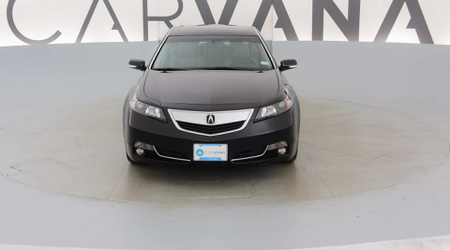

In [114]:
Image.fromarray(dataset[0], 'RGB') 

In [115]:
y_pred = model.predict_label(dataset[0])

# revert the dictionnary for fast query
numbertomakedict = {v: k for k, v in maketonumberdict.items()}
numbertomodeldict = {v: k for k, v in modeltonumberdict.items()}

# print answer of prediciton
print("Make: {}".format(numbertomakedict[y_pred[0][1]]))
print("Model: {}".format(numbertomodeldict[y_pred[0][2]]))


TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

Make: Mazda
Model: TL


In [40]:
numbertomakedict

{0: 'Acura',
 1: 'Mazda',
 2: 'Chevrolet',
 3: 'BMW',
 4: 'Honda',
 5: 'Buick',
 6: 'Kia',
 7: 'Toyota',
 8: 'Hyundai',
 9: 'Nissan',
 10: 'FIAT',
 11: 'Chrysler',
 12: 'INFINITI',
 13: 'Ford',
 14: 'Volkswagen',
 15: 'Dodge',
 16: 'Jeep',
 17: 'Cadillac',
 18: 'GMC',
 19: 'Lincoln',
 20: 'Lexus',
 21: 'Jaguar',
 22: 'Smart',
 23: 'Infiniti',
 24: 'Mercedes-Benz',
 25: 'Mitsubishi',
 26: 'MINI',
 27: 'Subaru',
 28: 'Audi',
 29: 'Land Rover'}

In [30]:
y_pred = model.predict_label(x)
y_pred[0][1]


2

In [29]:
predict = tf.argmax(x, dimension=1)
predict

<tf.Tensor 'ArgMax_5:0' shape=(1, 450, 3) dtype=int64>

## 2. With make and model

At this stage, we'll remove the vehicle ID from the labels to keep only make and model. It might be interesting later to add the vehicle ID to the training, to account for the repetitive number of photos from different angle. We'll keep it simple for now.

In [44]:
clean_y_train = clean_y_train.drop("name", axis = 1)
clean_y_train

,make,model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


### Reset underlying graph

In [45]:
# reset underlying graph data
tf.reset_default_graph()
tf.get_default_graph().get_operations()

os.chdir("C:/Users/mednche/Desktop/ImageRec/") # change directory to save checkpoint of model

### Define network architecture and train model

In [46]:
from sklearn.model_selection import train_test_split

with tf.Graph().as_default():
    
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, clean_y_train, test_size=0.2, random_state=33)
    
    # trainx and trainy should be numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Make sure the data is normalized
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()


    ### Define our network architecture:
    
    # Input is a tensor: height*width images with 3 color channels (red, green and blue) 
    
    network = input_data(shape=[None, image_height, image_width, channels],
                         data_preprocessing=img_prep)
    
    # Step 1: Convolution
    # NB: low level recognises edges and cruves, high level recognises beaks and paws 
    network = conv_2d(network, 3, 10, activation='relu') # number of filters: 3, filter size 3 
    # need downsampling to reduce the size of the image
    
    # Step 2: Max pooling
    network = max_pool_2d(network, 2) # kernel size
                        
    # Step 6: Fully-connected 3 node neural network
    # Looks at all images for each class and identify the high level features in common
    network = fully_connected(network, 2, activation='relu') # number of outputs = number of classes the model has to choose from
    
    network = tflearn.regression(network)
                             
    
    # Wrap the network in a model object
    model = tflearn.DNN(network, tensorboard_verbose=1, checkpoint_path='carclassifier.tfl.ckpt')
    
    %timeit model.fit(X_train, y_train, batch_size=2) # batch size of 56 or even 10 is too much
    
    # Save model when training is complete to a file
    model.save("carclassifier.tfl")
    
    print("Network trained and saved as car-classifier.tfl!")
    
    score = model.evaluate(X_test, y_test, batch_size=10)
    # accuracy 0.0010000000149011613
    
    print("Accuracy of the model: {}".format(score))


Training Step: 19999  | total loss: 0.00000 | time: 203.498s
| Adam | epoch: 010 | loss: 0.00000 -- iter: 3998/4000
Training Step: 20000  | total loss: 0.00000 | time: 203.583s
| Adam | epoch: 010 | loss: 0.00000 -- iter: 4000/4000
--
INFO:tensorflow:C:\Users\mednche\Desktop\ImageRec\carclassifier.tfl.ckpt-20000 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:C:\Users\mednche\Desktop\ImageRec\carclassifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as car-classifier.tfl!
Accuracy of the model: [0.0010000000149011613]


### Evaluate the performance of the model

In [16]:

y_pred = model.predict_label(X_test[100:140])
y_pred

array([[1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [1, 2, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0],
       [2, 1, 0]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# predict values
img
x = np.array(img, dtype=np.float32)
x = np.array(x).reshape(1, 250,450,3)

X_test

y_pred = model.predict_label(X_test[:80]) # cannot handle more (memory load)

y_pred
y_test[:5]


im = Image.open(folder + "/" + train_files[0])


# Confusion matrix
confusion_matrix(y_test, y_pred)

# Precision 
precision_score(y_test, y_pred)

# Recall
recall_score(y_test, y_pred)

# F1 score
f1_score(y_test,y_pred)

# Cohen's kappa
cohen_kappa_score(y_test, y_pred)
